Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6408 - loss: 0.6252 - val_accuracy: 1.0000 - val_loss: 0.1280
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0582 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 8.6761e-04
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 5.5872e-04
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 7.3949e-04 - val_accuracy: 1.0000 - val_loss: 4.1715e-04
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.1861e-04 - val_accuracy: 1.0000 - val_loss: 3.2994e-04
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.7305e-04 - val_accuracy: 1.0000 - val_loss: 2.6500e-04
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 3.5567e-04 -

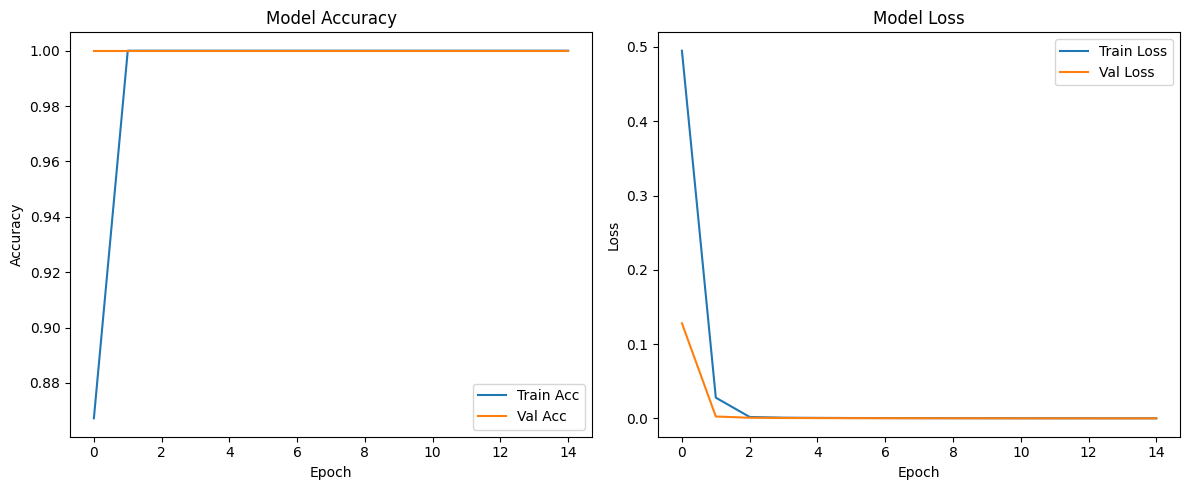

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Generate Synthetic Time-Series Data
def generate_lstm_data(samples=1000, timesteps=24):
    data = []
    labels = []

    for _ in range(samples):
        temp = np.random.normal(40, 5, timesteps)
        volt = np.random.normal(600, 50, timesteps)
        curr = np.random.normal(10, 2, timesteps)
        energy = (volt * curr * np.random.uniform(0.8, 1.0, timesteps)) / 1000
        maint = np.random.poisson(lam=2, size=timesteps)

        sequence = np.stack([temp, volt, curr, energy, maint], axis=1)
        data.append(sequence)

        failure_score = (
            (temp.mean() > 45).astype(int) +
            (volt.mean() < 550).astype(int) +
            (maint.mean() > 3).astype(int)
        )
        labels.append(1 if failure_score >= 2 else 0)

    return np.array(data), np.array(labels)

# Generate and scale the data
X, y = generate_lstm_data()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. Build LSTM Model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Train Model with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# 4. Evaluate Model
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.2f}")

# 5. Plot Training/Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
